In [ ]:
!pip install alibi-detect

In [ ]:
import logging
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
import tensorflow as tf
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Dense, InputLayer

from alibi_detect.datasets import fetch_kdd
from alibi_detect.models.tensorflow.losses import elbo
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.data import create_outlier_batch
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_tabular, plot_roc

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [ ]:
import os

In [ ]:
kddcup = fetch_kdd(percent10=True)  # only load 10% of the dataset
print(kddcup.data.shape, kddcup.target.shape)

(494021, 18) (494021,)


In [ ]:
np.random.seed(0)
normal_batch = create_outlier_batch(kddcup.data, kddcup.target, n_samples=400000, perc_outlier=0)
X_train, y_train = normal_batch.data.astype('float'), normal_batch.target
print(X_train.shape, y_train.shape)
print('{}% outliers'.format(100 * y_train.mean()))

(400000, 18) (400000,)
0.0% outliers


In [ ]:
mean, stdev = X_train.mean(axis=0), X_train.std(axis=0)

In [ ]:
print(mean)
print(stdev)

[1.09550075e+01 1.55620000e-03 1.74745000e-03 5.54626500e-02
 5.57733250e-02 9.85440925e-01 1.82663500e-02 1.33057100e-01
 1.48641492e+02 2.02133175e+02 8.44858050e-01 5.64032750e-02
 1.33479675e-01 2.40508250e-02 2.11637500e-03 1.05915000e-03
 5.73124750e-02 5.52324500e-02]
[2.17181039e+01 2.78305002e-02 2.61481724e-02 2.28073133e-01
 2.26952689e-01 9.25608777e-02 1.16637691e-01 2.77172101e-01
 1.03333220e+02 8.68577798e+01 3.05254458e-01 1.79868747e-01
 2.80221411e-01 4.92476707e-02 2.95181081e-02 1.59275611e-02
 2.24229381e-01 2.17798555e-01]


In [ ]:
_train = (X_train - mean) / stdev

In [ ]:
np.random.seed(0)
perc_outlier = 5
threshold_batch = create_outlier_batch(kddcup.data, kddcup.target, n_samples=1000, perc_outlier=perc_outlier)
X_threshold, y_threshold = threshold_batch.data.astype('float'), threshold_batch.target
X_threshold = (X_threshold - mean) / stdev
print('{}% outliers'.format(100 * y_threshold.mean()))

od.infer_threshold(X_threshold, threshold_perc=100-perc_outlier)
print('New threshold: {}'.format(od.threshold))


5.0% outliers
New threshold: 1.736781618554812


In [ ]:
load_outlier_detector = True

In [ ]:
filepath =  '/content'

In [ ]:
 
if load_outlier_detector:  # load pretrained outlier detector
    detector_type = 'outlier'
    dataset = 'kddcup'
    detector_name = 'OutlierVAE'
    od = fetch_detector(filepath, detector_type, dataset, detector_name)
    filepath = os.path.join(filepath, detector_name)
else:  # define model, initialize, train and save outlier detector
    n_features = X_train.shape[1]
    latent_dim = 2

    encoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(n_features,)),
          Dense(20, activation=tf.nn.relu),
          Dense(15, activation=tf.nn.relu),
          Dense(7, activation=tf.nn.relu)
      ])

    decoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(latent_dim,)),
          Dense(7, activation=tf.nn.relu),
          Dense(15, activation=tf.nn.relu),
          Dense(20, activation=tf.nn.relu),
          Dense(n_features, activation=None)
      ])

    # initialize outlier detector
    od = OutlierVAE(threshold=None,  # threshold for outlier score
                    score_type='mse',  # use MSE of reconstruction error for outlier detection
                    encoder_net=encoder_net,  # can also pass VAE model instead
                    decoder_net=decoder_net,  # of separate encoder and decoder
                    latent_dim=latent_dim,
                    samples=5)
    # train
    od.fit(X_train,
           loss_fn=elbo,
           cov_elbo=dict(sim=.01),
           epochs=30,
           verbose=True)

    # save the trained outlier detector
    save_detector(od, filepath)

In [ ]:
od.summary()

In [ ]:
np.random.seed(1)
outlier_batch = create_outlier_batch(kddcup.data, kddcup.target, n_samples=1000, perc_outlier=10)
X_outlier, y_outlier = outlier_batch.data.astype('float'), outlier_batch.target
X_outlier = (X_outlier - mean) / stdev
print(X_outlier.shape, y_outlier.shape)
print('{}% outliers'.format(100 * y_outlier.mean()))

(1000, 18) (1000,)
10.0% outliers


In [ ]:
od_preds = od.predict(X_outlier,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)
print(list(od_preds['data'].keys()))

['instance_score', 'feature_score', 'is_outlier']


F1 score: 0.9754


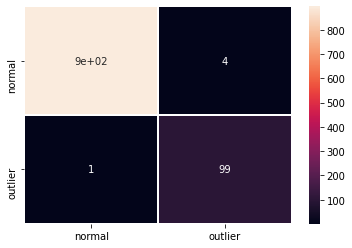

In [ ]:
labels = outlier_batch.target_names
y_pred = od_preds['data']['is_outlier']
f1 = f1_score(y_outlier, y_pred)
print('F1 score: {:.4f}'.format(f1))
cm = confusion_matrix(y_outlier, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=True, linewidths=.5)
plt.show()

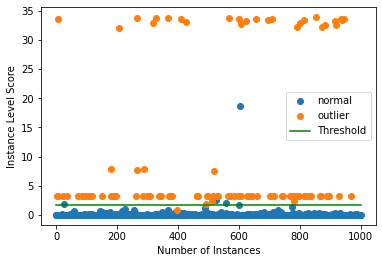

In [ ]:
plot_instance_score(od_preds, y_outlier, labels, od.threshold)